# Emotion Detection

## Importing libraries

In [2]:
import matplotlib.pyplot as plt
from glob import glob
import cv2
import random
import os
%matplotlib inline

from tensorflow.keras.preprocessing .image import ImageDataGenerator
from tensorflow.keras.layers import Dense, Input, Dropout, Flatten, Conv2D
from tensorflow.keras.layers import BatchNormalization, Activation, MaxPooling2D
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint, ReduceLROnPlateau
from tensorflow.keras.utils import plot_model

from IPython.display import SVG, Image
import tensorflow as tf
print("tensorflow version : ", tf.__version__)

tensorflow version :  2.16.1


## Exploring Dataset

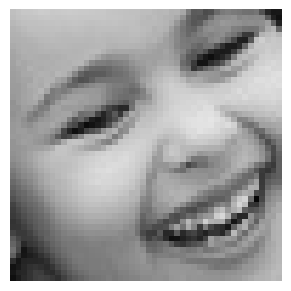

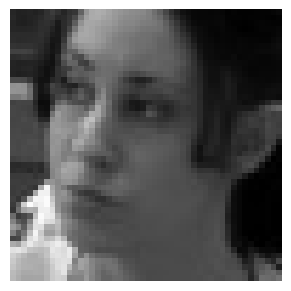

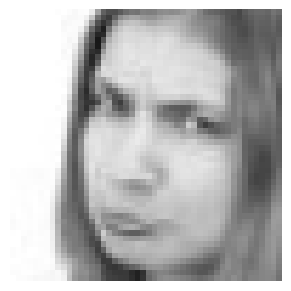

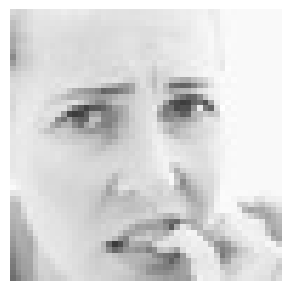

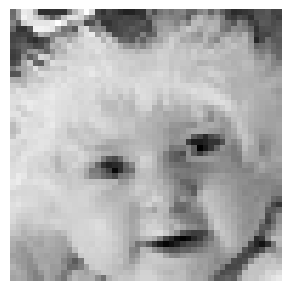

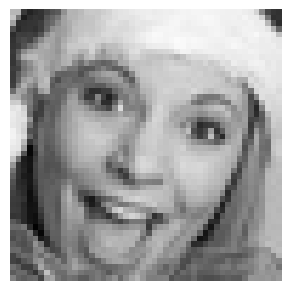

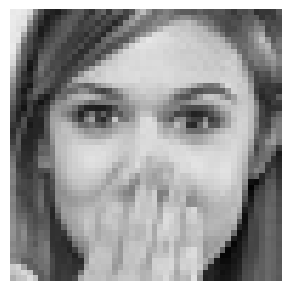

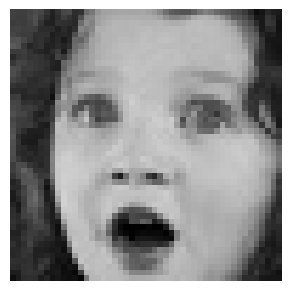

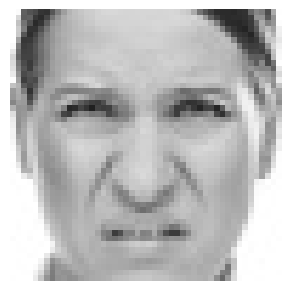

In [4]:
images = glob("train/**/**")
for i in range(9):
    image=random.choice(images)
    plt.figure(figsize=(12,12))
    plt.subplot(331+i)
    plt.imshow(cv2.imread(image))
    plt.axis('off')

## Preparing Data for Training

In [13]:
img_size = 48
batch_size = 64

datagen_train = ImageDataGenerator()
train_generator = datagen_train.flow_from_directory("train/", target_size=(img_size, img_size), color_mode="grayscale",
                                                   batch_size = batch_size, class_mode='categorical', shuffle=True)

datagen_validation = ImageDataGenerator()
validation_generator = datagen_train.flow_from_directory("test/", target_size=(img_size, img_size), color_mode="grayscale",
                                                   batch_size = batch_size, class_mode='categorical', shuffle=True)

Found 28709 images belonging to 7 classes.
Found 7178 images belonging to 7 classes.


## Defining Model

In [14]:
def Convolution(input_tensor, filters, kernel_size):
    x = Conv2D(filters=filters, kernel_size=kernel_size, padding='same')(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = MaxPooling2D(pool_size=(2,2))(x)
    x = Dropout(0.25)(x)
    
    return x

In [15]:
def Dense_f(input_tensor, nodes):
    x = Dense(nodes)(input_tensor)
    x = BatchNormalization()(x)
    x = Activation('relu')(x)
    x = Dropout(0.25)(x)

    return x

In [16]:
def model_fer(input_shape):
    inputs = Input(input_shape)
    conv_1 = Convolution(inputs, 32, (3,3))
    conv_2 = Convolution(inputs, 64, (5,5))
    conv_3 = Convolution(inputs, 128, (3,3))

    flatten  = Flatten()(conv_3)

    dense_1 = Dense_f(flatten, 256)

    output =  Dense(7, activation='softmax')(dense_1)

    model = Model(inputs=[inputs], outputs=[output])
    model.compile(loss=['categorical_crossentropy'], optimizer='adam', metrics=['accuracy'])

    return model

In [17]:
model = model_fer((48, 48, 1))
model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 48, 48, 1)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 48, 48, 128)         │           1,280 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 48, 48, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_6 (Activation)            │ (None, 48, 48, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 24, 24, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 73728)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 256)                 │      18,874,624 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 256)                 │           1,024 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_7 (Activation)            │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_7 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 7)                   │           1,799 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 18,879,239 (72.02 MB)

 Trainable params: 18,878,471 (72.02 MB)

 Non-trainable params: 768 (3.00 KB)

## Initializing Model

In [21]:
epochs = 15
steps_per_epoch = train_generator.n // train_generator.batch_size
validation_steps = validation_generator.n // validation_generator.batch_size

checkpoint = ModelCheckpoint("model.weights.h5", monitor='val_accuracy', save_weights_only=True, mode='max', verbose=1)
callbacks= [checkpoint]

## Training the Model

In [22]:
history = model.fit(
    x = train_generator, steps_per_epoch=steps_per_epoch, epochs=epochs, validation_data=validation_generator, validation_steps = validation_steps,
    callbacks=callbacks)

Epoch 1/15


C:\Users\gknts\anaconda3\Lib\site-packages\keras\src\trainers\data_adapters\py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.3314 - loss: 1.9001
Epoch 1: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 627s 1s/step - accuracy: 0.3315 - loss: 1.8996 - val_accuracy: 0.3881 - val_loss: 1.5747
Epoch 2/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:14 704ms/step - accuracy: 0.4219 - loss: 1.5668
Epoch 2: saving model to model.weights.h5


C:\Users\gknts\anaconda3\Lib\contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.4219 - loss: 1.5668 - val_accuracy: 0.4000 - val_loss: 1.3532
Epoch 3/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.4870 - loss: 1.3463
Epoch 3: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 605s 1s/step - accuracy: 0.4870 - loss: 1.3463 - val_accuracy: 0.3963 - val_loss: 1.5876
Epoch 4/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:15 705ms/step - accuracy: 0.4688 - loss: 1.3008
Epoch 4: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 2s 3ms/step - accuracy: 0.4688 - loss: 1.3008 - val_accuracy: 0.3000 - val_loss: 1.7898
Epoch 5/15
448/448 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5617 - loss: 1.1748
Epoch 5: saving model to model.weights.h5
448/448 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step - accuracy: 0.5616 - loss: 1.1748 - val_accuracy: 0.3975 - val_loss: 1.5807
Epoch 6/15
  1/448 ━━━━━━━━━━━━━━━━━━━━ 5:41 764ms/step - accuracy: 0.4688 - loss: 1.3284
Epoch 6: saving model to model.weights.h5
448/448 ━━━━

## Model Evaluation

In [23]:
model.evaluate(validation_generator)

113/113 ━━━━━━━━━━━━━━━━━━━━ 16s 141ms/step - accuracy: 0.4301 - loss: 1.9742


[1.9581526517868042, 0.43689051270484924]

## Plotting Loss

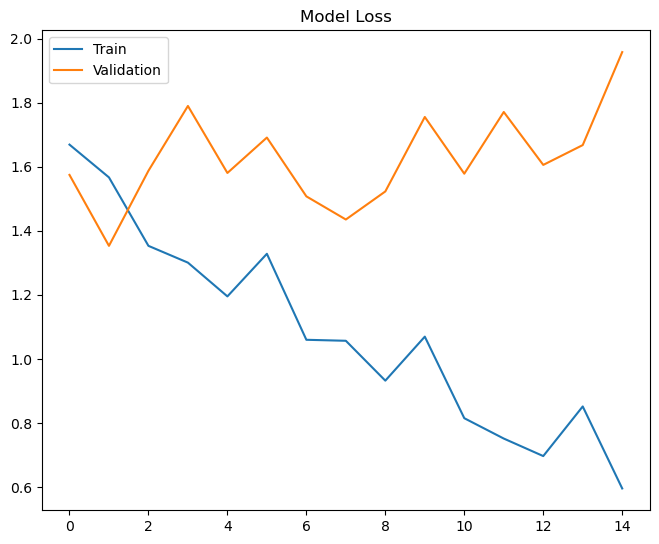

In [27]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

## Plotting Acccuracy

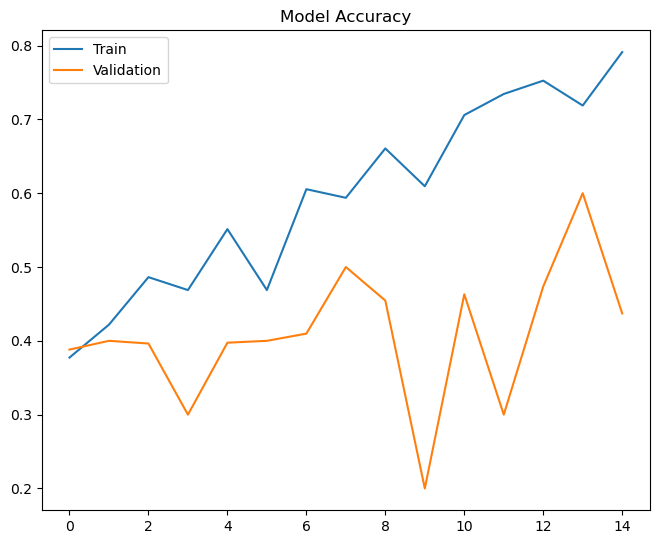

In [28]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.subplots_adjust(top=1.0, bottom=0.0, right=0.95, left=0.0, hspace=0.25, wspace=0.35)

## Saving Model

Model weights are saved while training using Model Checkpoints

In [29]:
model_json = model.to_json()
with open('model_a.json', 'w') as json_file:
    json_file.write(model_json)